In [9]:
!pip install tensorflow
import numpy as np
import pandas as pd
from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder

     |████████████████████████████████| 195.6 MB 80 kB/s s eta 0:00:01  |█▋                              | 9.7 MB 5.2 MB/s eta 0:00:37     |███                             | 18.4 MB 10.3 MB/s eta 0:00:18     |██████████████████████          | 134.1 MB 13.2 MB/s eta 0:00:05
     |████████████████████████████████| 57 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 23.7 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 27.3 MB/s eta 0:00:01     |██████████████████████████████▉ | 5.8 MB 27.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 6.4 MB/s eta 0:00:01
     |████████████████████████████████| 15.6 MB 8.5 MB/s eta 0:00:01     |█████████████████████████████   | 14.2 MB 8.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 13

In [10]:
from pyod.models.iforest import IForest
from sklearn.model_selection import train_test_split

In [11]:
data = pd.read_csv('inpatientCharges.csv')

In [12]:
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']

In [13]:
data['DRG'] = data['DRG'].astype('category')
data['Provider_State'] = data['Provider_State'].astype('category')
data['Provider_City'] = data['Provider_City'].astype('category')
data['Provider_Id'] = data['Provider_Id'].astype('category')
data['Average_Covered_Charges'] = (data['Average_Covered_Charges']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Total_Payments'] = (data['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


In [14]:
benchmark = data.groupby(['Provider_State','DRG'])['Average_Total_Payments'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_ByStateDRG']
benchmark.head()
feature1 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature1['ratio_amount1'] = feature1.Average_Total_Payments / feature1.Avg_Payment_ByStateDRG
feature1.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByStateDRG,ratio_amount1
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,5658.33,1.021015
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,5658.33,1.022841
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,5658.33,0.960522
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,5658.33,0.957449
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,5658.33,1.000000


In [15]:
data['Patient_pay'] =data.Average_Total_Payments - data.Average_Medicare_Payment
benchmark = data.groupby(['Provider_State','DRG'])['Patient_pay'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Patient_Payment_ByStateDRG']
benchmark.head()
feature2 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature2['ratio_amount2'] = feature2.Patient_pay / feature2.Avg_Patient_Payment_ByStateDRG
feature2.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Avg_Patient_Payment_ByStateDRG,ratio_amount2
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,803.365,0.915487
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,803.365,1.714837
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,803.365,2.048882
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,803.365,1.013923
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,803.365,0.812009


In [16]:
data['Diff_between_patient_and_medicare_pay'] =data.Average_Medicare_Payment - data.Patient_pay
benchmark = data.groupby(['Provider_State','DRG'])['Diff_between_patient_and_medicare_pay'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_difference_in_patient_and_medicare_Payment_ByStateDRG']
benchmark.head()
feature3 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature3['ratio_amount3'] = feature3.Diff_between_patient_and_medicare_pay / feature3.Avg_difference_in_patient_and_medicare_Payment_ByStateDRG
feature3.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Avg_difference_in_patient_and_medicare_Payment_ByStateDRG,ratio_amount3
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,3750.22,3472.63,1.079937
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86,4165.85,3472.63,1.199624
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16,3472.63,3472.63,1.000000
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40,2840.76,3472.63,0.818043
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89,4044.55,3472.63,1.164694


In [17]:
data['Payment_over_covered_ratio'] =data.Average_Total_Payments/data.Average_Covered_Charges
benchmark = data.groupby(['Provider_State','DRG'])['Payment_over_covered_ratio'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_over_covered_ratio_ByStateDRG']
benchmark.head()
feature4 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature4['ratio_amount4'] = feature4.Payment_over_covered_ratio / feature4.Avg_Payment_over_covered_ratio_ByStateDRG
feature4.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Avg_Payment_over_covered_ratio_ByStateDRG,ratio_amount4
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,2335.92,0.144668,0.225312,0.642079
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,1272.08,0.185552,0.225312,0.823533
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,2412.36,0.145811,0.225312,0.647148
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,6033.99,0.265406,0.225312,1.177947
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,2235.07,0.235324,0.225312,1.044436


In [18]:
data['Out_of_Pocket_ratio'] =data.Patient_pay/data.Average_Total_Payments
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Out_of_Pocket_ratio'].median().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Out_of_Pocket_ratio_ByRegionDRG']
benchmark.head()
feature5 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp','DRG'])
# ratio
feature5['ratio_amount5'] = feature5.Out_of_Pocket_ratio / feature5.Avg_Out_of_Pocket_ratio_ByRegionDRG
feature5.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Out_of_Pocket_ratio,Avg_Out_of_Pocket_ratio_ByRegionDRG,ratio_amount5
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,2335.92,0.144668,0.193196,0.193196,1.000000
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,1272.08,0.185552,0.342070,0.188083,1.818716
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,2412.36,0.145811,0.288551,0.193196,1.493567
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,6033.99,0.265406,0.106295,0.182380,0.582824
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,2235.07,0.235324,0.184290,0.182380,1.010473


In [19]:
data['Patinet_pay_over_covered'] =data.Patient_pay/data.Average_Covered_Charges
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Patinet_pay_over_covered'].median().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Patinet_pay_over_covered']
benchmark.head()
feature6 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp','DRG'])
# ratio
feature6['ratio_amount6'] = feature6.Patinet_pay_over_covered / feature6.Avg_Patinet_pay_over_covered
feature6.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Out_of_Pocket_ratio,Patinet_pay_over_covered,Avg_Patinet_pay_over_covered,ratio_amount6
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,2335.92,0.144668,0.193196,0.027949,0.034718,0.805041
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,1272.08,0.185552,0.342070,0.063472,0.040151,1.580839
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,2412.36,0.145811,0.288551,0.042074,0.034718,1.211875
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,6033.99,0.265406,0.106295,0.028211,0.040339,0.699365
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,2235.07,0.235324,0.184290,0.043368,0.040339,1.075098


In [20]:
data['ratio_amount1']=feature1['ratio_amount1']
data['ratio_amount2']=feature2['ratio_amount2']
data['ratio_amount3']=feature3['ratio_amount3']
data['ratio_amount4']=feature4['ratio_amount4']
data['ratio_amount5']=feature5['ratio_amount5']
data['ratio_amount6']=feature6['ratio_amount6']

data.head()


,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Out_of_Pocket_ratio,Patinet_pay_over_covered,ratio_amount1,ratio_amount2,ratio_amount3,ratio_amount4,ratio_amount5,ratio_amount6
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,3750.22,0.175264,0.175432,0.030747,1.021015,0.971875,1.079937,0.817735,0.995540,1.124531
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4165.85,0.382476,0.140104,0.053586,1.022841,0.777550,1.199624,1.784531,0.759423,2.051369
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,3472.63,0.144699,0.180528,0.026122,0.960522,0.940854,1.000000,0.675127,0.978540,1.000000
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,2840.76,0.387016,0.237819,0.092040,0.957449,1.235472,0.818043,1.805713,1.289084,3.523433
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,...,4044.55,0.178873,0.142602,0.025508,1.000000,0.773743,1.164694,0.834572,0.772966,0.976473


# AutoEncoder

In [116]:
x = data.iloc[:, -6:]
x.isna().value_counts()
#There is no missing value within features

ratio_amount1  ratio_amount2  ratio_amount3  ratio_amount4  ratio_amount5  ratio_amount6
False          False          False          False          False          False            163065
dtype: int64

In [117]:
x['Y'] = 0
X = x.iloc[:, -7:-1]
Y = x['Y']
X.head()

,ratio_amount1,ratio_amount2,ratio_amount3,ratio_amount4,ratio_amount5,ratio_amount6
0,1.021015,0.971875,1.079937,0.817735,0.995540,1.124531
1,1.022841,0.777550,1.199624,1.784531,0.759423,2.051369
2,0.960522,0.940854,1.000000,0.675127,0.978540,1.000000
3,0.957449,1.235472,0.818043,1.805713,1.289084,3.523433
4,1.000000,0.773743,1.164694,0.834572,0.772966,0.976473


In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.3, random_state=42)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [119]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [120]:
X_train.shape

(114145, 6)

In [121]:
X_train.describe()

,0,1,2,3,4,5
count,1.141450e+05,1.141450e+05,1.141450e+05,1.141450e+05,1.141450e+05,1.141450e+05
mean,5.081397e-16,3.734948e-17,3.607960e-16,-2.273338e-16,3.137356e-17,1.979522e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.487159e+00,-1.273859e+00,-5.107196e+01,-2.095515e+00,-1.914647e+00,-1.470822e+00
25%,-5.909487e-01,-3.727203e-01,-4.980711e-01,-6.326551e-01,-4.346657e-01,-4.456690e-01
50%,-2.409533e-01,-2.231489e-01,-1.291363e-01,-1.659159e-01,-1.750922e-01,-1.733603e-01
75%,2.901759e-01,3.917510e-02,3.354283e-01,3.994267e-01,1.430479e-01,1.604251e-01
max,3.904747e+01,8.152371e+01,1.369804e+01,2.089672e+01,2.849672e+01,7.151972e+01


Autoencoder is about dimension reduction. The inner layers should always have less neurons than the outer layer. By reducing the number of neurons through the layers, we can eliminate noises and thus gain insights on outliers.

In my first model, I attempted with two inner layers

In [122]:
clf1 = AutoEncoder(hidden_neurons =[6, 2, 2, 6])
clf1.fit(X_train)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_26 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_27 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_28 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                

3211/3211 [==============================] - 5s 2ms/step - loss: 0.9174 - val_loss: 0.8140
Epoch 60/100
3211/3211 [==============================] - 5s 1ms/step - loss: 0.9163 - val_loss: 0.8041
Epoch 61/100
3211/3211 [==============================] - 5s 1ms/step - loss: 0.9168 - val_loss: 0.8132
Epoch 62/100
3211/3211 [==============================] - 5s 1ms/step - loss: 0.9159 - val_loss: 0.8018
Epoch 63/100
3211/3211 [==============================] - 4s 1ms/step - loss: 0.9166 - val_loss: 0.8104
Epoch 64/100
3211/3211 [==============================] - 4s 1ms/step - loss: 0.9189 - val_loss: 0.8069
Epoch 65/100
3211/3211 [==============================] - 5s 1ms/step - loss: 0.9137 - val_loss: 0.8038
Epoch 66/100
3211/3211 [==============================] - 5s 1ms/step - loss: 0.9166 - val_loss: 0.8055
Epoch 67/100
3211/3211 [==============================] - 5s 1ms/step - loss: 0.9162 - val_loss: 0.8051
Epoch 68/100
3211/3211 [==============================] - 5s 1ms/step - loss:

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[6, 2, 2, 6],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7ff9c045f158>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [123]:
y_train_scores = clf1.decision_scores_ 

In [124]:
y_train_scores = clf1.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf1.predict(X_test)  # outlier labels (0 or 1)
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf1.decision_function(X_test)  # outlier scores

y_test_pred = pd.Series(y_test_pred)
y_test_scores = pd.Series(y_test_scores)

In [125]:
y_test_pred.value_counts()

0    44064
1     4856
dtype: int64

Cluster 1 is about 10% of the total data

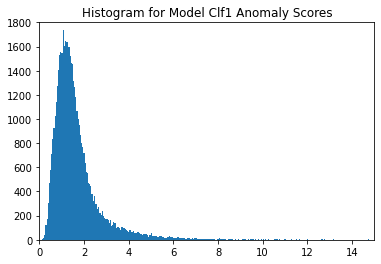

In [126]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf1 Anomaly Scores")
plt.axis([0, 15,0,1800])
plt.show()

In [130]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<7, 0, 1)
df_test['cluster'].value_counts()

0    48443
1      477
Name: cluster, dtype: int64

In [131]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,score
cluster,,,,,,,
0,-0.028505,-0.047939,-0.002047,-0.017267,-0.041296,-0.043722,1.613584
1,2.894873,4.868569,0.207902,1.753635,4.193955,4.440309,11.174407


The difference in score/distance between points suggest the model is doing a good job grouping the outliers to cluster 1

In the second model, I added one more inner layer to the model.

In [132]:
clf2 = AutoEncoder(hidden_neurons =[6, 4,2, 4, 6])
clf2.fit(X_train)

# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_32 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_38 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_33 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 6)                 42        
_________________________________________________________________
dropout_34 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 4)                

3211/3211 [==============================] - 5s 2ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 58/100
3211/3211 [==============================] - 4s 1ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 59/100
3211/3211 [==============================] - 5s 2ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 60/100
3211/3211 [==============================] - 5s 2ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 61/100
3211/3211 [==============================] - 5s 2ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 62/100
3211/3211 [==============================] - 5s 2ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 63/100
3211/3211 [==============================] - 5s 2ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 64/100
3211/3211 [==============================] - 5s 2ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 65/100
3211/3211 [==============================] - 5s 2ms/step - loss: 1.0084 - val_loss: 0.9243
Epoch 66/100
3211/3211 [==============================] - 5s 1ms/step - loss:

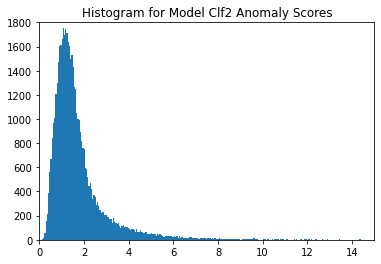

In [133]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for Model Clf2 Anomaly Scores")
plt.axis([0, 15,0,1800])
plt.show()

In [134]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<7, 0, 1)
df_test['cluster'].value_counts()

0    48235
1      685
Name: cluster, dtype: int64

In [135]:
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,score
cluster,,,,,,,
0,-0.035108,-0.063654,0.001990,-0.020742,-0.055956,-0.057986,1.661550
1,2.472138,4.482266,-0.140147,1.460537,3.940205,4.083133,10.878899


By adding a layer, the score in cluster 1(outliers) decreased but the number of data points in the outlier cluster increased.

# Aggregating for Autoencoder with average method

In [136]:
from pyod.models.combination import aom, moa, average, maximization

# Put all the predictions in a data frame
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_
                            })

test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test)
                            })

In [137]:
train_scores.head()

,clf1,clf2
0,1.100399,1.085083
1,3.137003,3.148130
2,2.148233,2.586328
3,1.232642,1.306008
4,2.742069,2.752101


In [138]:
test_scores.head()

,clf1,clf2
0,1.423451,1.413928
1,0.842291,0.840818
2,1.476700,1.473765
3,0.628051,0.615278
4,1.234163,1.225529


In [139]:
from pyod.utils.utility import standardizer
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

In [140]:
train_scores_norm.shape

(114145, 2)

In [141]:
y_by_average = average(test_scores_norm)
y_by_average[1:10]

array([-0.56869026, -0.1693948 , -0.70705352, -0.32391554, -0.08641419,
        0.88566638, -0.27886639,  0.34437064, -0.62186006])

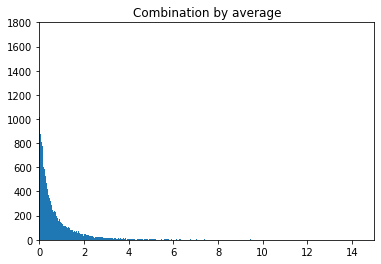

In [142]:
y_by_average = average(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.axis([0, 15,0,1800])
plt.show()

As expected, by aggregating, the cutoff point seems smaller than previous models

In [144]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<4, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    48538
1      382
Name: y_by_average_cluster, dtype: int64

Cluster 1 ize also seem to be reduced to 382

In [145]:
df_test.groupby('y_by_average_cluster').mean()

,0,1,2,3,4,5,y_by_average_score
y_by_average_cluster,,,,,,,
0,-0.022561,-0.044559,0.002079,-0.013162,-0.039887,-0.041221,-0.052893
1,2.866675,5.661770,-0.264128,1.672402,5.068092,5.237635,6.911922


Finally, the y score for cluster 1 on average is not as extreme as in previous models. Negative y score for cluster 0 could be interpreted as distance between data points are minimal.

# Iforest

Isolated forest follows similar principles as random forest, built on the basis of decision tree. However, random forest focus on profiling normal data points. Isolated forest is used to identifies anomalies or outliers. Isolated forest use number of depth(number of cuts) to determine anomolies, those who have less cuts are clustered into cluster 1.

In [146]:
x = data.iloc[:, -6:]
x['Y'] = 0
X = x.iloc[:, -7:-1]
Y = x['Y']
X.head()

,ratio_amount1,ratio_amount2,ratio_amount3,ratio_amount4,ratio_amount5,ratio_amount6
0,1.021015,0.971875,1.079937,0.817735,0.995540,1.124531
1,1.022841,0.777550,1.199624,1.784531,0.759423,2.051369
2,0.960522,0.940854,1.000000,0.675127,0.978540,1.000000
3,0.957449,1.235472,0.818043,1.805713,1.289084,3.523433
4,1.000000,0.773743,1.164694,0.834572,0.772966,0.976473


In [147]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)
X.head()

,0,1,2,3,4,5
0,-0.140595,-0.254384,0.104237,-0.605240,-0.183811,-0.014224
1,-0.131961,-0.459772,0.454669,1.726180,-0.592490,1.185192
2,-0.426662,-0.287171,-0.129809,-0.949138,-0.213235,-0.175379
3,-0.441196,0.024220,-0.662559,1.777262,0.324266,3.090180
4,-0.239973,-0.463796,0.352397,-0.564637,-0.569050,-0.205825


In [148]:
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.33, random_state=42)

In [149]:
X_train.shape

(109253, 6)

In [150]:
X_test.shape

(53812, 6)

In [157]:
clf1 = IForest(behaviour="new",max_samples = 500) 
clf1.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=500, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [158]:
y_test_scores = clf1.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.079341
1   -0.131317
2   -0.121642
3   -0.132335
4   -0.120287
dtype: float64

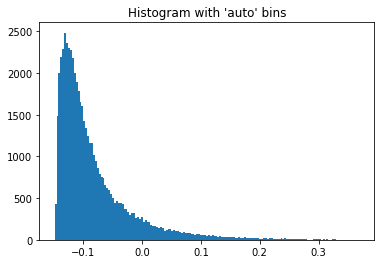

In [159]:
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [160]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.2, 0, 1)
X_test_cluster['cluster'].value_counts()

1    36306
0    17506
Name: cluster, dtype: int64

In [161]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,distance
cluster,,,,,,,
0,-0.008814,0.043939,-0.018138,-0.002750,0.035795,0.025906,-0.084617
1,0.000950,-0.017688,0.008532,-0.000801,-0.010771,-0.005140,0.244390


In [89]:
clf2 = IForest(behaviour="new", max_samples=80) 
clf2.fit(X_train)

IForest(behaviour='new', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples=80, n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [90]:
y_test_scores = clf2.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)
y_test_scores.head()

0   -0.106855
1   -0.167592
2   -0.135673
3   -0.173320
4   -0.156488
dtype: float64

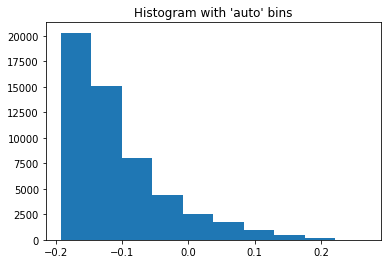

In [92]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins=10)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [93]:
X_test_cluster = X_test.copy()
X_test_cluster['distance'] = y_test_scores
X_test_cluster['cluster'] = np.where(X_test_cluster['distance']<0.2, 0, 1)
X_test_cluster['cluster'].value_counts()

1    36206
0    17606
Name: cluster, dtype: int64

In [94]:
X_test_cluster.groupby('cluster').mean()

,0,1,2,3,4,5,distance
cluster,,,,,,,
0,-0.009295,0.043410,-0.018058,-0.003654,0.035295,0.025172,-0.106724
1,0.001211,-0.017601,0.008566,-0.000356,-0.010656,-0.004869,0.217770


# Model aggregating for Isolated forest with Maximization

In [95]:
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(X_test),
                             'clf2': clf2.decision_function(X_test)
                            })

In [96]:
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

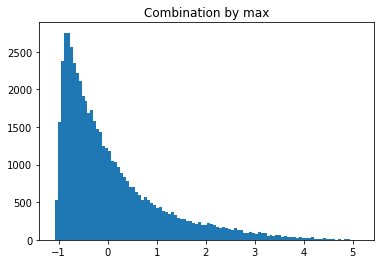

In [97]:
y_by_maximization = maximization(test_scores_norm)
             
import matplotlib.pyplot as plt
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [98]:
df_test = pd.DataFrame(X_test)
df_test['y_by_maximization_score'] = y_by_maximization
df_test['y_by_maximization_cluster'] = np.where(df_test['y_by_maximization_score']<4, 0, 1)
df_test['y_by_maximization_cluster'].value_counts()

0    53603
1      209
Name: y_by_maximization_cluster, dtype: int64

Interesting fact here, by aggregating, the cutoff for iforest actually is greater than the previous iforest models.

In [99]:
df_test.groupby('y_by_maximization_cluster').mean()

,0,1,2,3,4,5,y_by_maximization_score
y_by_maximization_cluster,,,,,,,
0,-0.012029,-0.030215,0.009481,-0.004421,-0.026962,-0.027545,0.040619
1,2.511896,8.357022,-2.468755,0.764337,8.042253,8.341580,4.321848


The difference of the distance/yscore between 2 clusters acutally signified

Both models(autoencoder,isolated forest) identified resonable size of cluster 1 and the difference in y score between cluster 0and1 is sufficient enough to determine the outliers.